In [1]:
### Peasy 21 (Python Easy 12 - or just easy peasy lemon squeezy)

We need a couple of functions for drawing cards:


SyntaxError: invalid syntax (<ipython-input-1-e2b50dca7965>, line 3)

In [2]:
import numpy as np

def drawCard():
    return np.random.randint(1,11)

def pickCol():
    if np.random.uniform() < 1/3:
        col = -1
    else:
        col = +1
    return col

In my implementation the state is represented by a pair, the dealer's first card and player's sum, so initially both draw a single card using drawCard() which is by default Black (+ve), and so the initial state is

s = [drawCard(), drawCard()]

There are only two actions for the player to pick from: "Hit" (a = 0) and "Stick" (a = 1)

When the player asks for a "Hit", then we only need to update s[0] by adding to it drawCard() $\times$ pickCol()
and as long as our sum is between 1 and 21 we can continue the game.

However, if out player choosed to "Stick", the we must play let the dealer play out his game (fixed policy), and return the reaward, as follows:

In [3]:
def playoutDealer(s):
    if (s[0] > 21) | (s[0] < 1):
        return -1.0
    while s[1] < 17:
        s[1] = s[1] + drawCard() * pickCol()
        if (s[1] > 21) | (s[1] < 1):
            return 1.0
    if (s[1] > s[0]):
        return -1.0
    if (s[0] > s[1]):
        return 1.0
    return 0.0

### Implementation of Q-learning

We complete the implentation of the game and add during game play Q-learning to establish the optimal action-value function in the form of a table called Q which is a 3D matrix taking in the arguments (playerSum, dealerCard, action):

In [4]:
Qoptimal = np.zeros((22,11,2)) 

We did not ask for Q-learning, however, Q learning will give you the optimal action-value function. We will first need to implement a softmax policy, we will use $\epsilon$-greedy:

In [5]:
def epsGreedy(epsilon, Q, s):
    action = np.array([0,1])
    if np.random.uniform() < epsilon:
        return action[np.random.randint(0,2)]
    return action[np.argmax(Q[s[0],s[1],:])]

In [6]:
def playEasy21Qlearning(Q, N):
    gamma = 1.0
    N0 = 100.0
    dealerCard = drawCard()
    playerCard = drawCard()
    s = [playerCard, dealerCard]
    epsilon = N0/(N0 + N[s[0],s[1],:].sum())
    a = epsGreedy(epsilon, Q, s)
    N[s[0],s[1],a] += 1
    while a == 0:
        card = drawCard() * pickCol()
        snew = [s[0]+card, s[1]]
        if (snew[0] > 21) | (snew[0] < 1):
            break
        epsilon = N0/(N0 + N[snew[0],snew[1],:].sum())
        anew = epsGreedy(epsilon, Q, snew)
        Q[s[0],s[1],a] = Q[s[0],s[1],a] + (1/N[s[0],s[1],a])*(0 + Q[snew[0],snew[1],:].max() - Q[s[0],s[1],a])
        s = snew
        a = anew
        N[s[0],s[1],a] += 1
    r = playoutDealer(np.copy(s))
    Q[s[0],s[1],a] = Q[s[0],s[1],a] + (1/N[s[0],s[1],a])*(r + 0 - Q[s[0],s[1],a])

We will use the same anealing scheme for $\epsilon$ as specified by the assigment for the MC and SARSA experiments, for this reason we need to count how often we visit state s and take action a. You will notice that within the while loop the reward is zero and only when exiting the loop (game over) can we figure out the outcome of the game (playoutDealer(s))

In [7]:
N = np.zeros((22,11,2))
for episode in range(100000):
    playEasy21Qlearning(Qoptimal, N)

Now lets take a look at the value function:

Text(0.5, 0.92, 'probability of winning')

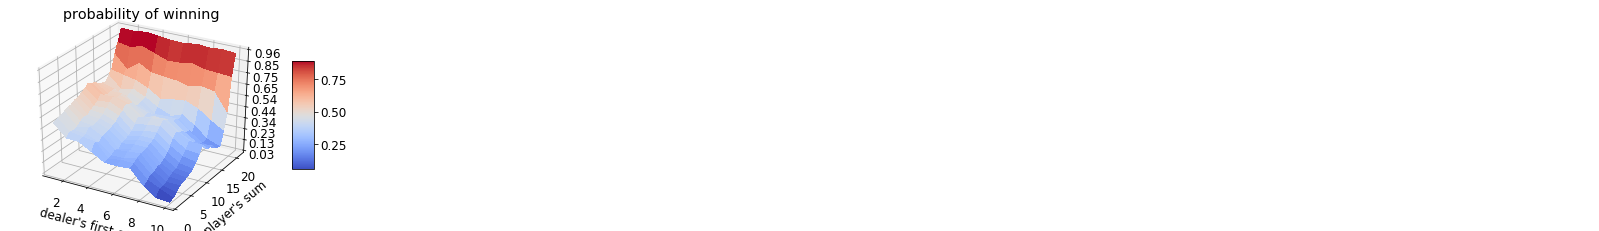

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

plt.rcParams.update({'font.size': 12})
ax = plt.gca(projection = '3d')
P, D = np.meshgrid(range(11), range(22))
V = np.max(Qoptimal, axis = 2)
surf = ax.plot_surface(P[1:,1:], D[1:,1:], V[1:,1:], cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.colorbar(surf, shrink = 0.5, aspect = 5)
plt.ylabel("player's sum")
plt.xlabel("dealer's first card")
plt.title("probability of winning")



The result is somewhat similar to the Blackjack example, however, there is no drop in value when th dealer is showing "1" (the Ace), which has a special meaning in Blackjack.

### MC  and SARSA experiment

We are now ready to some experiments, in my solution I decides to use the Q-learning to solve for the optimal state action value. Furthermore, MC is equivalent to SARSA(1) and so is uncluded in the SARSA($\lambda$) experiments. We now define SARSA($\lambda$):

In [9]:
def playEasy21sarsa(Q, N, lam):
    gamma = 1.0
    N0 = 100.0
    E = np.zeros((22,11,2))
    dealerCard = drawCard()
    playerCard = drawCard()
    s = [playerCard, dealerCard]
    epsilon = N0/(N0 + N[s[0],s[1],:].sum())
    a = epsGreedy(epsilon, Q, s)
    N[s[0],s[1],a] += 1
    while a == 0:
        card = drawCard() * pickCol()
        snew = [s[0]+card, s[1]]
        if (snew[0] > 21) | (snew[0] < 1):
            break
        epsilon = N0/(N0 + N[snew[0],snew[1],:].sum())
        anew = epsGreedy(epsilon, Q, snew)
        delta = 0 + gamma * Q[snew[0],snew[1],anew] - Q[s[0],s[1],a]
        E[s[0],s[1],a] += 1
        Q[E > 0] = Q[E > 0] + delta * E[E > 0] * (1/N[E > 0])
        E = gamma * lam * E       
        s = snew
        a = anew
        N[s[0],s[1],a] += 1
    r = playoutDealer(np.copy(s))
    delta = r + gamma * 0 - Q[s[0],s[1],a]
    E[s[0],s[1],a] +=  1
    Q[E > 0] = Q[E > 0] + delta * E[E > 0] * (1/N[E > 0])

and now we perform all the experiments:

In [10]:
def experiment(lam):   
    mse = np.zeros((lam.size,1000))
    for k in range(lam.size):
        Q = np.zeros((22,11,2))
        N = np.zeros((22,11,2))
        for j in range(1000):
            for i in range(1):
                playEasy21sarsa(Q, N, lam[k])
            squares = (Qoptimal[1:,1:,:] - Q[1:,1:,:])**2
            mse[k,j] = squares.mean()
    return mse

and now lets run them for differen $\lambda$:

In [11]:
lam = np.array([0.0,0.2,0.4,0.6,0.8,1.0])
mse = experiment(lam)  

Lets plot the convergence for the extreme cases MC/SARSA(1) versus SARSA(0) and actually I plot for all $\lambda$ studied.

Text(0, 0.5, 'MSE')

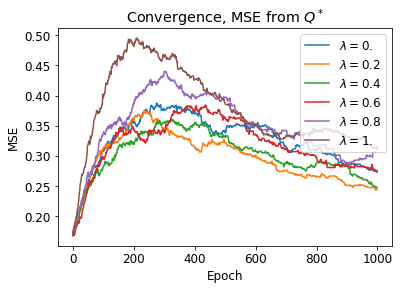

In [12]:
for i in range(lam.size):
    plt.plot(range(1000),mse[i,:], label = "$\lambda=$" + np.array2string(lam[i]))
plt.legend(loc='upper right')
plt.title("Convergence, MSE from $Q^*$")
plt.xlabel("Epoch")
plt.ylabel("MSE")

From this we see that $\lambda=0$ is better than MC ($\lambda=1$), but which $\lambda$ is best in terms of MSE after 1000 epochs ?!

Text(0, 0.5, 'MSE')

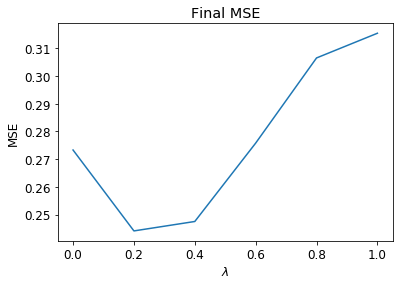

In [13]:
plt.plot(lam,mse[:,-1])
plt.title("Final MSE")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")

The results here may vary, to get a reliable result you would need to replicate this experiment many times (100) and take the average.